In [1]:
'https://www.kaggle.com/code/himanshu007121/covid-19-cough-classification/notebook'

'https://www.kaggle.com/code/himanshu007121/covid-19-cough-classification/notebook'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library import

In [3]:
## basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## sk
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

## tf
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics, utils
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
import librosa
from keras import backend as K

## ect
import timeit
import cv2
import glob
import pickle
from tqdm.auto import tqdm
import os
import random
import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

## Data Load

In [5]:
raw_path = '/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/raw'
extracted_path = '/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/extracted'
submit_path = '/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/submit'

In [6]:
audio_path_train = raw_path + '/train/'
audio_list_train = os.listdir(raw_path + '/train')
audio_list_train.sort()

In [7]:
path_train = raw_path + '/train/'
train_df = pd.read_csv( raw_path + '/train_data.csv')
test_df = pd.read_csv( raw_path + '/test_data.csv')

In [8]:
# train_df['file_name'] = audio_list_train
# train_df

## Hyperparameter Setting

In [9]:
CFG = {
    'SR': 16000,
    'N_MFCC': 32, # MFCC 벡터를 추출할 개수
    'SEED': 0xC0FFEE
}

## Fixed Random-Seed

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-Processing(MFCC)

In [11]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = raw_path
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [12]:
get_mfcc_feature(train_df, 'train', extracted_path + '/train_mfcc_data.csv')
get_mfcc_feature(test_df, 'test', extracted_path + '/test_mfcc_data.csv')

/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/extracted/train_mfcc_data.csv is exist.
/content/drive/MyDrive/Dacon/음향_데이터_covid-19_검출_AI_경진대회/data/extracted/test_mfcc_data.csv is exist.


In [13]:
train_df = pd.read_csv(extracted_path + '/train_mfcc_data.csv')
test_df = pd.read_csv(extracted_path + '/test_mfcc_data.csv')

In [14]:
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32
0,1,24,female,0,1,0,-274.93472,29.345425,-19.152718,-7.836881,...,-2.320942,2.150005,-0.925417,2.116030,-0.192730,2.417784,-4.736650,1.237788,-1.600426,-1.462419
1,2,51,male,0,0,0,-311.55988,52.482780,-0.094471,-11.066645,...,-6.497138,0.543653,-6.263890,-2.386007,-6.744628,0.254181,-0.967560,-2.113267,-2.433431,0.881612
2,3,22,male,0,0,0,-438.28616,46.591045,-22.690268,-3.606580,...,-0.156195,-1.680287,2.617625,1.242552,-0.073267,-0.961353,-0.733599,-0.419574,0.796274,0.412893
3,4,29,female,1,0,0,-368.42603,46.939438,-7.443070,-3.694368,...,-0.155832,3.839320,-2.503331,2.750769,1.758514,2.094565,0.295820,1.737585,-0.654200,1.847927
4,5,23,male,0,0,0,-535.19300,7.167374,-7.420830,2.231418,...,-0.144892,-0.412889,-1.451348,0.237435,-0.971688,0.779251,-0.734346,1.141693,-0.498866,1.189332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,3801,53,male,0,0,0,-328.48108,68.198110,-40.380050,2.296546,...,-0.169228,1.255069,-4.971604,-0.051959,1.205788,3.960530,-4.198615,2.740852,-4.145076,-2.578391
3801,3802,25,male,0,0,0,-386.11325,74.041670,-12.082752,-0.463326,...,-2.914988,4.903864,1.143663,6.106156,2.849517,3.576305,-0.653661,3.850693,2.524862,5.940696
3802,3803,26,female,0,0,0,-347.16568,58.591610,12.996252,27.981964,...,-2.394710,-2.743319,-2.632139,-1.907922,-3.182673,-1.444413,-0.020416,-1.599742,-1.627819,-1.380630
3803,3804,27,female,0,0,0,-179.06174,70.699880,-14.584357,-10.161293,...,-7.737086,5.680622,-2.050983,1.687631,-1.204141,-0.130723,-4.725782,0.556226,-5.252555,-0.278517


In [15]:
test_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32
0,3806,48,female,1,0,-619.98790,9.328649,0.821094,2.373343,-0.171163,...,-0.313271,-0.053711,-0.029855,0.043562,-0.405293,-0.246975,-0.110937,0.019196,-0.155829,-0.130705
1,3807,24,female,0,0,-493.60570,8.492651,-2.758262,-2.801817,-2.770231,...,-0.677968,-0.643835,-0.822677,-0.113844,-1.210391,0.273594,-0.685921,0.440101,-0.960277,0.371881
2,3808,29,male,0,0,-1058.84180,-2.350609,-7.395449,-0.689041,-5.432969,...,-0.015659,3.134083,2.587130,0.463058,-0.127755,1.612876,-3.393354,-2.874998,-1.302709,-2.915723
3,3809,39,female,0,0,-362.16165,27.119740,-9.231675,9.747519,-1.013352,...,-3.150051,-0.271802,0.034900,0.414227,-2.836006,0.105023,0.518484,2.139494,0.944032,1.029428
4,3810,34,male,0,0,-387.59268,45.165874,-14.454832,-2.965205,-9.931789,...,-4.803990,-3.594220,0.289146,-5.298121,1.614137,3.108044,-5.373443,0.106868,2.054100,-1.994548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,9533,43,male,0,0,-363.15244,48.035835,6.562373,11.678885,-7.902833,...,-2.375794,1.897672,1.334932,-0.633910,1.072993,-1.663435,-5.812972,-1.345760,-1.715584,-0.579053
5728,9534,48,female,0,1,-650.22455,2.844074,2.063639,5.160136,-4.574105,...,-1.014055,0.853542,-0.998176,0.421669,-0.817565,1.201457,-1.148051,0.335183,0.076959,-0.215559
5729,9535,44,female,0,0,-335.09128,54.100250,-15.533144,13.702870,-9.206227,...,-2.222736,-2.004309,-2.250272,-1.290327,-2.485475,-1.268755,-4.346352,0.055307,-1.181318,0.464578
5730,9536,25,female,0,0,-534.98730,17.522040,-9.687601,5.585782,-8.310497,...,-1.565546,-1.021776,-1.453681,-1.553367,-1.581636,-1.428654,-1.613187,-0.816451,-0.766406,0.130751


In [16]:
# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv(extracted_path + '/train_mfcc_data.csv')

# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']

In [17]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [18]:
# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)

In [19]:
train_x.shape

(3805, 38)

In [20]:
train_y.shape

(3805,)

In [21]:
train_y = utils.to_categorical(train_y)

In [22]:
train_y.shape

(3805, 2)

## tensorflow.Keras.models

- Sequential

In [23]:
3805*38

144590

In [ ]:
model.add(layers.Dense(units=10, activation='softmax'))
model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,        # <- Label이 One-hot 형태일 경우
              metrics=['accuracy']) 

In [24]:
#Building the layers
model = models.Sequential() 

##layer
model.add(layers.Dense(input_dim= 38, units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=128, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 512)               19968     
                                                                 
 batch_normalization_30 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 512)               0         
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_31 (Bat  (None, 256)              1024      
 chNormalization)                                    

In [25]:
####Compile the models
model.compile(optimizer='adam',
              loss=losses.binary_crossentropy, 
              metrics=['accuracy', f1score])

model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy', f1score]) 

In [26]:
##### Training
history = model.fit(train_x, train_y, batch_size=10, epochs=400, validation_split=0.2)

Epoch 1/400
305/305 [==============================] - 6s 6ms/step - loss: 0.3279 - accuracy: 0.9021 - f1score: 0.9023 - val_loss: 0.3816 - val_accuracy: 0.8699 - val_f1score: 0.8714
Epoch 2/400
305/305 [==============================] - 1s 5ms/step - loss: 0.2986 - accuracy: 0.9202 - f1score: 0.9203 - val_loss: 0.3425 - val_accuracy: 0.9080 - val_f1score: 0.9091
Epoch 3/400
305/305 [==============================] - 1s 5ms/step - loss: 0.2898 - accuracy: 0.9215 - f1score: 0.9211 - val_loss: 0.3319 - val_accuracy: 0.9001 - val_f1score: 0.9013
Epoch 4/400
305/305 [==============================] - 1s 5ms/step - loss: 0.2888 - accuracy: 0.9228 - f1score: 0.9229 - val_loss: 0.3060 - val_accuracy: 0.9080 - val_f1score: 0.9091
Epoch 5/400
305/305 [==============================] - 1s 5ms/step - loss: 0.2812 - accuracy: 0.9221 - f1score: 0.9223 - val_loss: 0.2976 - val_accuracy: 0.9080 - val_f1score: 0.9091
Epoch 6/400
305/305 [==============================] - 1s 5ms/step - loss: 0.2781 - a

### Test the model

In [27]:
# 위의 학습데이터를 전처리한 과정과 동일하게 test data에도 적용
test_x = pd.read_csv(extracted_path + '/test_mfcc_data.csv')
test_x = test_x.drop(columns=['id'])
# Data Leakage에 유의하여 train data로만 학습된 ohe를 사용
test_x = onehot_encoding(ohe, test_x)

In [28]:
test_x.head()

,age,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,female,male,other
0,48,1,0,-619.98790,9.328649,0.821094,2.373343,-0.171163,-1.189314,-3.113831,...,0.043562,-0.405293,-0.246975,-0.110937,0.019196,-0.155829,-0.130705,1.0,0.0,0.0
1,24,0,0,-493.60570,8.492651,-2.758262,-2.801817,-2.770231,1.993531,-5.280821,...,-0.113844,-1.210391,0.273594,-0.685921,0.440101,-0.960277,0.371881,1.0,0.0,0.0
2,29,0,0,-1058.84180,-2.350609,-7.395449,-0.689041,-5.432969,1.596380,-8.221005,...,0.463058,-0.127755,1.612876,-3.393354,-2.874998,-1.302709,-2.915723,0.0,1.0,0.0
3,39,0,0,-362.16165,27.119740,-9.231675,9.747519,-1.013352,-4.020472,-13.982765,...,0.414227,-2.836006,0.105023,0.518484,2.139494,0.944032,1.029428,1.0,0.0,0.0
4,34,0,0,-387.59268,45.165874,-14.454832,-2.965205,-9.931789,10.073367,-0.863068,...,-5.298121,1.614137,3.108044,-5.373443,0.106868,2.054100,-1.994548,0.0,1.0,0.0


In [29]:
result = model.evaluate(train_x, test_x, batch_size=100)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])
print('test f1score :', result[2])
print('test  val_accuracy :', result[3])

NameError: ignored

In [30]:
# Model 추론
preds = model.predict(test_x)

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1score', 'val_loss', 'val_accuracy', 'val_f1score'])

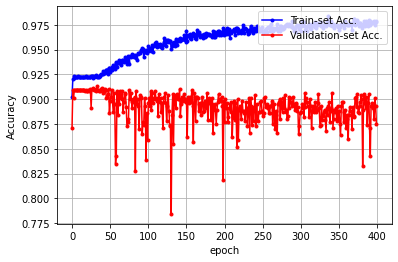

In [32]:
val_acc = history.history['val_f1score']
acc = history.history['f1score']

import numpy as np
import matplotlib.pyplot as plt

x_len = np.arange(len(acc))
plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [33]:
preds2  = np.argmax(preds, axis =1)

In [35]:
submission = pd.read_csv(raw_path + '/sample_submission.csv', index_col=0)
submission['covid19'] = preds2
submission.to_csv(submit_path + 'losses_categorical_crossentropy.csv', index='id')

In [36]:
submission

,covid19
id,
3806,0
3807,0
3808,0
3809,0
3810,0
...,...
9533,0
9534,0
9535,0
